# NicheCompass Multimodal Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 18.05.2023
- **Date of Last Modification:** 14.07.2023

In this tutorial, we apply NicheCompass to a single multimodal sample (postnatal day 22 coronal section) of a spatial ATAC-RNA-seq mouse brain dataset from [Zhang, D. et al. Spatial epigenome–transcriptome co-profiling of mammalian tissues. Nature 1–10 (2023)](https://www.nature.com/articles/s41586-023-05795-1).

The sample has:
- 9215 observations at spot resolution with spot rna cluster and atac cluster annotations
- 22,914 probed genes
- 121,068 called peaks

- Check the repository [README.md](https://github.com/sebastianbirk/nichecompass#installation) for NicheCompass installation instructions.
- The data for this tutorial can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/data/spatial_omics/```.
    - spatial_atac_rna_seq_mouse_brain_atac.h5ad
    - spatial_atac_rna_seq_mouse_brain.h5ad
- A pretrained model to run only the analysis can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/artifacts/multimodal/<timestamp>/model/```.
    - 02062023_151955

## 1. Setup

### 1.1 Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                add_multimodal_mask_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                create_new_color_dict,
                                extract_gp_dict_from_collectri_tf_network,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                get_gene_annotations,
                                generate_enriched_gp_info_plots,
                                generate_multimodal_mapping_dict,
                                get_unique_genes_from_gp_dict)

### 1.2 Define Parameters

In [4]:
### Dataset ###
dataset = "spatial_atac_rna_seq_mouse_brain"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 8
n_sampled_neighbors = 4
filter_genes = True
n_hvg = 3000
filter_peaks = True
min_cell_peak_thresh_ratio = 0.0005 # 0.05%

### GP Mask ###
add_collectri_gps = True
add_marker_genes_gps = False

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.05
conv_layer_encoder = "gcnconv"
node_label_method = "one-hop-norm" # one-hop-attention

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_chrom_access_recon = 100.
lambda_l1_masked = 10.
lambda_l1_addon = 20.
lambda_group_lasso = 0.
l1_targets_categories = ["target_gene"] # targets categories to which l1 regularization will be applied
l1_sources_categories = ["enzyme"] # sources categories to which l1 regularization will be applied
edge_batch_size = 512 # reduce if not enough memory
use_cuda_if_available = True

### Analysis ###
rna_cluster_key = "RNA_clusters"
atac_cluster_key = "ATAC_clusters"
latent_leiden_resolution = 0.6
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 30
agg_weights_key = "agg_weights"
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [5]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [6]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [7]:
# Define paths
ga_data_folder_path = "../data/gene_annotations"
gp_data_folder_path = "../data/gene_programs"
so_data_folder_path = "../data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
marker_gp_folder_path = f"{gp_data_folder_path}/marker_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
gtf_file_path = f"{ga_data_folder_path}/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz"
artifacts_folder_path = f"../artifacts"
model_folder_path = f"{artifacts_folder_path}/multimodal/{current_timestamp}/model"

## 2. Model Preparation

### 2.1 Create Prior Knowledge Cell-Cell-Interaction (CCI) Gene Program (GP) Mask

- NicheCompass expects a prior CCI GP mask as input, which it will use to make its latent embedding interpretable (through a linear masked decoder). 
- The user can provide a custom GP mask to NicheCompass based on the dataset, application, and hypothesis of interest.
- As a default, we create a GP mask based on four databases of prior CCI knowledge:
    - OmniPath
    - NicheNet
    - MEBOCOST
    - CollecTRI

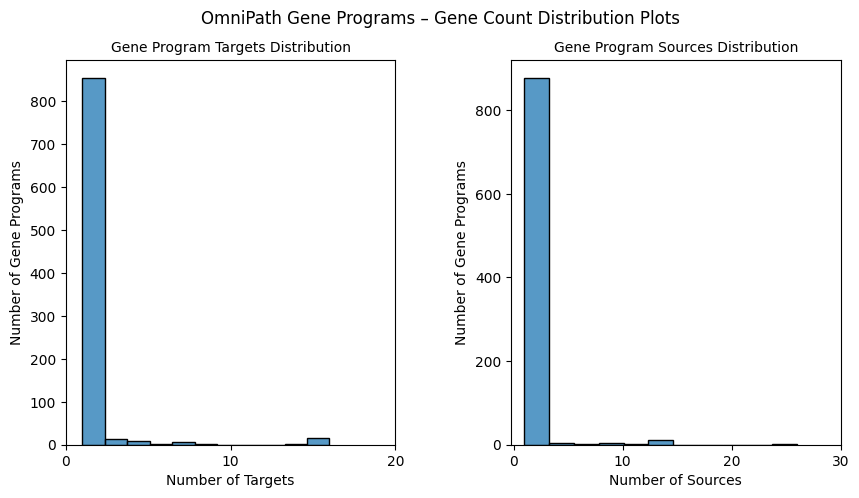

In [8]:
# Retrieve OmniPath GPs (source: ligand gene; target: receptor gene)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from OmniPath GPs to keep
# those genes when filtering
omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [9]:
# Display example OmniPath GPs
for i, (key, value) in enumerate(omnipath_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

BDNF_ligand_receptor_GP {'sources': ['Bdnf'], 'targets': ['Drd4'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}
EPOR_ligand_receptor_GP {'sources': ['Epor'], 'targets': ['Stat3'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}
FYN_ligand_receptor_GP {'sources': ['Fyn'], 'targets': ['Mapk7'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


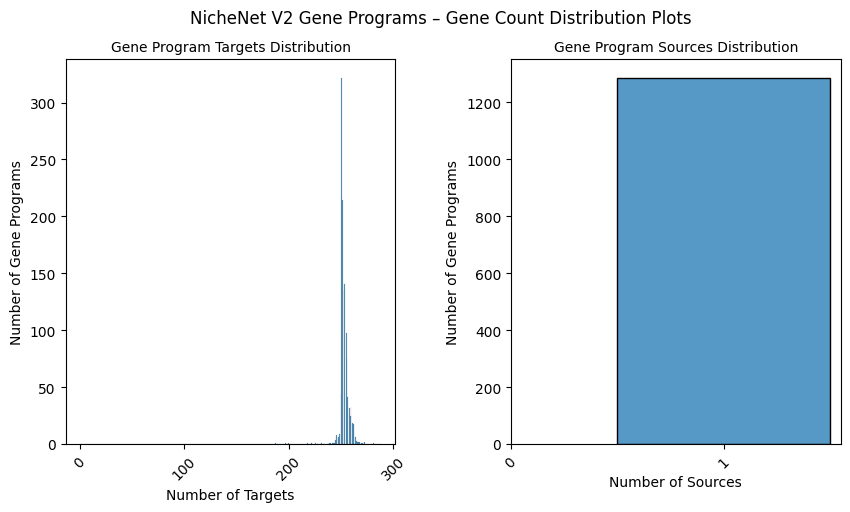

In [10]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source genes from NicheNet GPs to keep
# those genes when filtering
nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

In [11]:
# Display example NicheNet GPs
for i, (key, value) in enumerate(nichenet_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

2300002M23Rik_ligand_receptor_target_gene_GP {'sources': ['2300002M23Rik'], 'targets': ['Ddr1', 'Adm', 'Agt', 'Angptl4', 'Ankrd1', 'App', 'Ar', 'Ass1', 'Atf3', 'Bax', 'Bcl2', 'Bcl2l1', 'Bcl2l11', 'Bcl3', 'Bcl6', 'Bdnf', 'Bhlhe40', 'Bin1', 'Birc3', 'Birc5', 'Bmp4', 'Bnip3l', 'Bnip3l-ps', 'Brca1', 'Btg2', 'Cav1', 'Cbx5', 'Ccl12', 'Ccl20', 'Ccl5', 'Ccn1', 'Ccn2', 'Ccna2', 'Ccnb1', 'Ccnb1-ps', 'Ccnd1', 'Ccnd2', 'Cd5l', 'Cdc6', 'Cdca7', 'Cdh1', 'Cdk1', 'Cdk4', 'Cdk6', 'Cdkn1a', 'Cdkn1b', 'Cdkn2a', 'Cdkn2c', 'Cebpa', 'Cflar', 'Cited2', 'Csf2', 'Cxcr4', 'Cyp1a1', 'Cyp1b1', 'Cyp24a1', 'Cyp3a13', 'Ddit3', 'Ddit4', 'Dhrs3', 'Dkk1', 'Dtl', 'Dusp1', 'Dusp6', 'E2f1', 'E2f3', 'Edn1', 'Egfr', 'Egr1', 'Egr2', 'Enc1', 'Eno1', 'Eno1b', 'Epha2', 'Esr1', 'Etfb', 'Fas', 'Fasn', 'Fkbp5', 'Fn1', 'Fos', 'Fosl1', 'Foxo3', 'Fst', 'Gadd45a', 'Gadd45b', 'Gadd45g', 'Gapdh', 'Gapdh-ps15', 'Gata3', 'Gdf15', 'Gm10358', 'Gm3839', 'Gm40460', 'Gm4559', 'Gm45618', 'H2bc14', 'H3f3b', 'H4c12', 'H4c14', 'Hes1', 'Hmga1', 'Hm

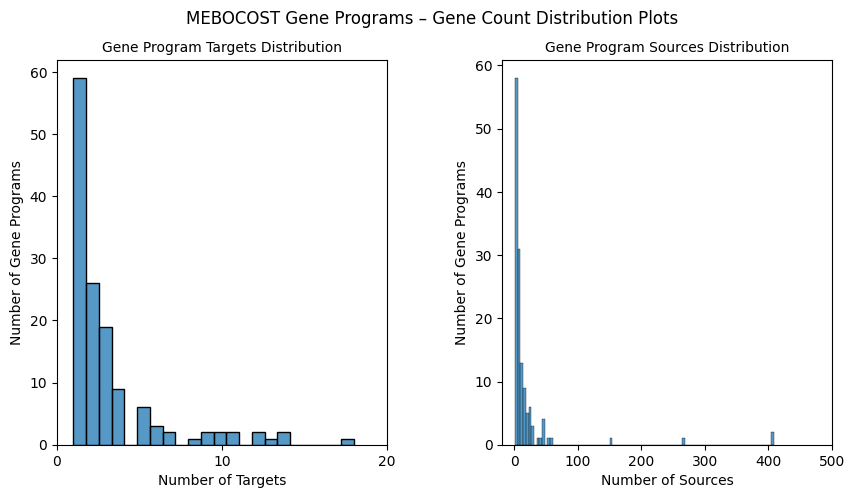

In [12]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from MEBOCOST GPs to keep
# those genes when filtering
mebocost_genes = get_unique_genes_from_gp_dict(
    gp_dict=mebocost_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [13]:
# Display example MEBOCOST GPs
for i, (key, value) in enumerate(mebocost_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

Deoxyuridine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Pnp', 'Pnp2', 'Tk1', 'Tk2', 'Tymp'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc29a2'], 'targets_categories': ['sensor']}
Deoxycytidine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Dck', 'Nt5c', 'Nt5c1a', 'Nt5c1b', 'Nt5c2', 'Nt5e', 'Nt5m'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc29a2'], 'targets_categories': ['sensor']}
3-Methoxytyramine_metabolite_enzyme_sensor_GP {'sources': ['Comt', 'Maoa', 'Maob'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme'], 'targets': ['Taar1'], 'targets_categories': ['sensor']}


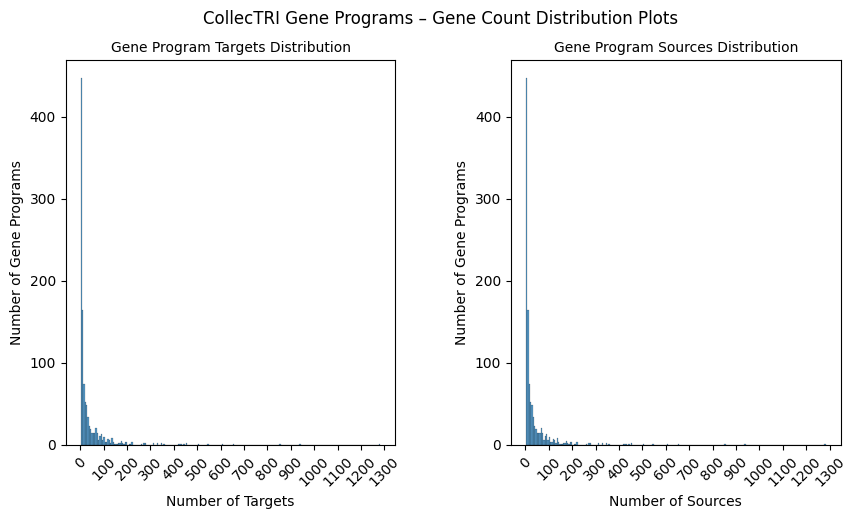

In [14]:
if add_collectri_gps:
    collectri_gp_dict = extract_gp_dict_from_collectri_tf_network(
        species=species,
        tf_network_file_path=collectri_tf_network_file_path,
        load_from_disk=True,
        save_to_disk=True,
        plot_gp_gene_count_distributions=True)

In [15]:
if add_collectri_gps:
    # Display example CollecTRI GPs
    for i, (key, value) in enumerate(collectri_gp_dict.items()):
        if i > 2:
            break
        print(key, value)

Abl1_TF_target_genes_GP {'sources': ['Abl1', 'Jun', 'Bcl6', 'Tp53', 'Bax', 'Bcl2', 'Ccnd2', 'Cdkn1a', 'Csf1', 'Foxo3', 'Pim1'], 'targets': ['Abl1', 'Jun', 'Bcl6', 'Tp53', 'Bax', 'Bcl2', 'Ccnd2', 'Cdkn1a', 'Csf1', 'Foxo3', 'Pim1'], 'sources_categories': ['tf', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene'], 'targets_categories': ['tf', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene', 'target_gene']}
Adnp_TF_target_genes_GP {'sources': ['Adnp', 'Becn1'], 'targets': ['Adnp', 'Becn1'], 'sources_categories': ['tf', 'target_gene'], 'targets_categories': ['tf', 'target_gene']}
Adnp2_TF_target_genes_GP {'sources': ['Adnp2', 'Hbb-b1'], 'targets': ['Adnp2', 'Hbb-b1'], 'sources_categories': ['tf', 'target_gene'], 'targets_categories': ['tf', 'target_gene']}


In [16]:
# Add spatial layer marker gene GPs (optional)
if add_marker_genes_gps:
    # Load experimentially validated marker genes
    validated_marker_genes_df = pd.read_csv(f"{gp_data_folder_path}/marker_gps/Validated_markers_MM_layers.tsv",
                                            sep="\t",
                                            header=None,
                                            names=["gene_name", "ensembl_id", "layer"])
    validated_marker_genes_df = validated_marker_genes_df[["layer", "gene_name"]]
    
    # Load ranked marker genes and get top 100 per layer
    ranked_marker_genes_df = pd.DataFrame()
    for ranked_marker_genes_file_name in [
        "Ranked_mm_L2L3.tsv",
        "Ranked_mm_L4.tsv",
        "Ranked_mm_L5.tsv",
        "Ranked_mm_L6.tsv",
        "Ranked_mm_L6b.tsv"]:
        ranked_marker_genes_layer_df = pd.read_csv(
            f"{gp_data_folder_path}/marker_gps/{ranked_marker_genes_file_name}",
            sep="\t",
            header=None,
            names=["ensembl_id", "gene_name", "layer"])
        ranked_marker_genes_layer_df = ranked_marker_genes_layer_df[:100] # filter top 100 genes
        ranked_marker_genes_layer_df = ranked_marker_genes_layer_df[["layer", "gene_name"]]
        ranked_marker_genes_df = pd.concat([ranked_marker_genes_df, ranked_marker_genes_layer_df])
    marker_genes_df = pd.concat([validated_marker_genes_df, ranked_marker_genes_df])
        
    marker_genes_grouped_df = marker_genes_df.groupby("layer")["gene_name"].agg(list).reset_index()
    marker_genes_grouped_df.columns = ["layer", "marker_genes"]
    marker_genes_grouped_df["layer"] = marker_genes_grouped_df["layer"] + "_marker_GP"
                                                               
    marker_genes_gp_dict = {}
    for layer, marker_genes in zip(marker_genes_grouped_df["layer"], marker_genes_grouped_df["marker_genes"]):
        marker_genes_gp_dict[layer] = {
            "sources": marker_genes,
            "targets": marker_genes,
            "sources_categories": ["marker"] * len(marker_genes),
            "targets_categories": ["marker"] * len(marker_genes)}

In [17]:
if add_marker_genes_gps:
    # Display example marker gene GPs
    for i, (key, value) in enumerate(marker_genes_gp_dict.items()):
        if i > 2:
            break
        print(key, value)

In [18]:
# Add GPs into one combined dictionary
# for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)
if add_collectri_gps:
    combined_gp_dict.update(collectri_gp_dict)    
if add_marker_genes_gps:
    combined_gp_dict.update(marker_genes_gp_dict)

In [19]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 3396.
Number of gene programs after filtering and combining: 2766.


### 2.2 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the dataset, application, and hypothesis of interest.
- In the multimodal setting, we will provide one adata object per modality to NicheCompass.

In [20]:
# Read data
adata = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}.h5ad")
adata_atac = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_atac.h5ad")

In [21]:
# Compute (separate) spatial neighborhood graphs
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Filter Genes & Peaks

In [22]:
if filter_genes:
    print("Filtering genes...")
    # Filter genes and only keep ligand, receptor, metabolite enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    sc.pp.highly_variable_genes(
        adata,
        layer=counts_key,
        n_top_genes=n_hvg,
        flavor="seurat_v3",
        subset=False)

    # Get gene program relevant genes
    gp_relevant_genes = [gene.upper() for gene in list(set(
        omnipath_genes + nichenet_source_genes + mebocost_genes))]
    
    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    
if filter_peaks:
    print("\nFiltering peaks...")
    print(f"Starting with {len(adata_atac.var_names)} peaks.")
    # Filter out peaks that are rarely detected to reduce GPU footprint of model
    min_cells = int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)
    sc.pp.filter_genes(adata_atac, min_cells=min_cells)
    print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
          f"counts in less than {int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)} cells.")

Filtering genes...
Starting with 22914 genes.
Keeping 22914 genes after filtering genes with expression in 0 cells.
Keeping 5184 highly variable or gene program relevant genes.

Filtering peaks...
Starting with 121068 peaks.
Keeping 121068 peaks after filtering peaks with counts in less than 4 cells.


### 2.4 Annotate Genes & Peaks

Next, we will add positional bp annotations to genes and peaks to be able to match spatially proximal peaks to genes.

In [23]:
adata, adata_atac = get_gene_annotations(
    adata=adata,
    adata_atac=adata_atac,
    gtf_file_path=gtf_file_path)

In [24]:
# Display gene annotations
adata.var[["chrom", "chromStart", "chromEnd"]]

,chrom,chromStart,chromEnd
Ppp1r14c,chr10,3366056.0,3464975.0
Iyd,chr10,3540239.0,3554877.0
Mthfd1l,chr10,3973117.0,4167081.0
Ccdc170,chr10,4482501.0,4562231.0
Esr1,chr10,4611592.0,5005614.0
...,...,...,...
Hccs,chrX,169250192.0,169320372.0
Asmt,chrX,170672643.0,170678054.0
Ddx3y,chrY,1260770.0,1286629.0
Erdr1,chrX,170009658.0,170019281.0


In [25]:
# Display peak annotations
adata_atac.var[["chrom", "chromStart", "chromEnd"]]

,chrom,chromStart,chromEnd
chr1:3094734-3095650,chr1,3094734,3095650
chr1:3119757-3120179,chr1,3119757,3120179
chr1:3120267-3120653,chr1,3120267,3120653
chr1:3121314-3122051,chr1,3121314,3122051
chr1:3264998-3265766,chr1,3264998,3265766
...,...,...,...
GL456216.1:31908-32576,GL456216.1,31908,32576
GL456216.1:43983-44510,GL456216.1,43983,44510
GL456216.1:48771-49683,GL456216.1,48771,49683
JH584292.1:12571-13497,JH584292.1,12571,13497


### 2.5 Add GP Mask to Data

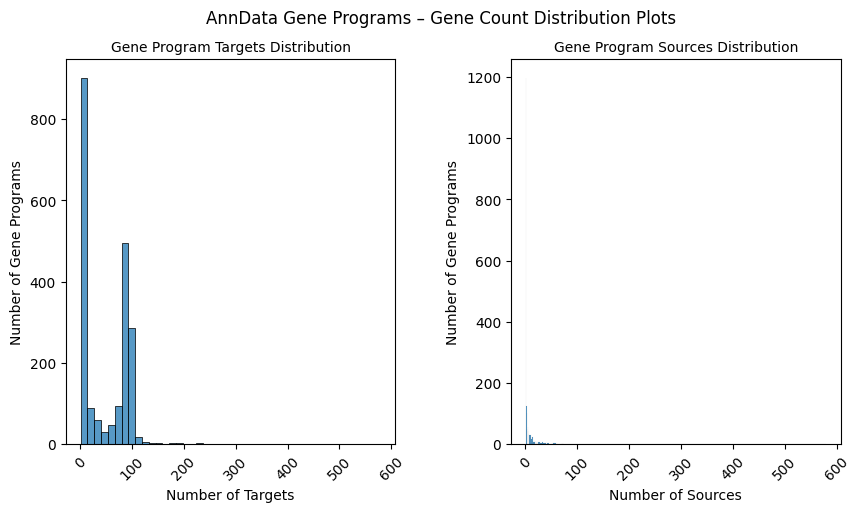

In [26]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    plot_gp_gene_count_distributions=True)

### 2.6 Add Chromatin Accessibility Mask to Data

Based on spatial proximity to the genes in the GP mask, we will add a chromatin accessibility mask.

In [27]:
gene_peak_mapping_dict = generate_multimodal_mapping_dict(
    adata=adata,
    adata_atac=adata_atac)

window_graph:   0%|          | 0/4899 [00:00<?, ?it/s]

In [28]:
adata, adata_atac = add_multimodal_mask_to_adata(
    adata=adata,
    adata_atac=adata_atac,
    gene_peak_mapping_dict=gene_peak_mapping_dict)

print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
      "no matching genes in gp mask.")

Keeping 24221 peaks after filtering peaks with no matching genes in gp mask.


### 2.7 Explore Data

In [29]:
rna_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=rna_cluster_key)

atac_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=atac_cluster_key)

Number of nodes (observations): 9215
Number of gene node features: 4899
Number of peak node features: 24221


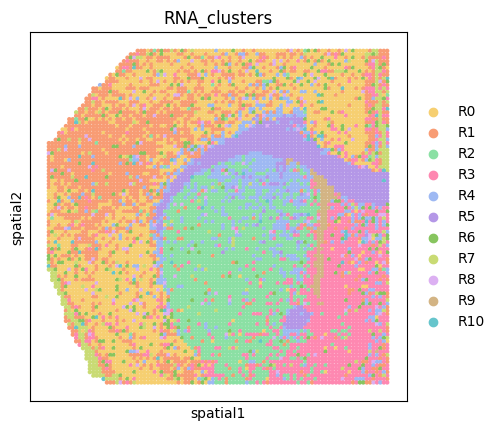

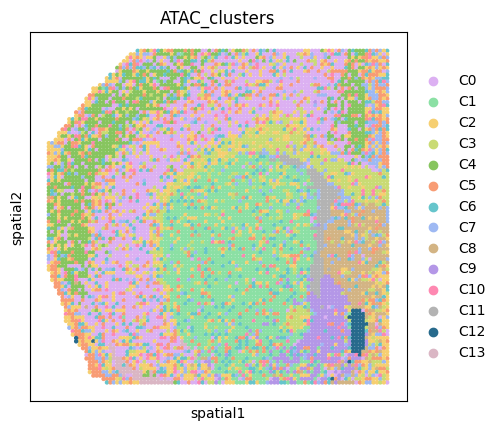

In [30]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of gene node features: {adata.layers['counts'].shape[1]}")
print(f"Number of peak node features: {adata_atac.layers['counts'].shape[1]}")

# Visualize spot-level annotated data in physical space
sc.pl.spatial(adata,
              color=rna_cluster_key,
              palette=rna_cluster_colors,
              spot_size=spot_size)
sc.pl.spatial(adata_atac,
              color=atac_cluster_key,
              palette=atac_cluster_colors,
              spot_size=spot_size) 

## 3. Model Training

### 3.1 Initialize, Train & Save Model

In [31]:
# Initialize model
model = NicheCompass(adata,
                     adata_atac,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     n_fc_layers_encoder=1,
                     n_addon_gp=0,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio,
                     node_label_method=node_label_method)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb, include_chrom_access_recon_loss: True, atac_recon_loss: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.05
LOG VARIATIONAL -> True
ONE HOP GCN NORM NODE LABEL AGGREGATOR
ENCODER -> n_input: 29120, n_cat_covariates_embed_input: 0, n_layers: 1, n_hidden: 2041, n_latent: 2041, n_addon_latent: 0, n_fc_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 2041, n_addon_gp_input: 0, n_cat_covariates_embed_input: 0, n_output: 4899
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 2041, n_addon_gp_input: 0, n_cat_covariates_embed_input: 0, n_output: 4899
MASKED TARGET ATAC DECODER -> n_prior_gp_input: 2041, n_addon_gp_input: 0, n_cat_covariates_embed_input: 0, n_output: 24221
MASKED SOURCE A

In [32]:
lambda_edge_recon = 500000

In [33]:
lambda_gene_expr_recon = 3000

In [34]:
lambda_chrom_access_recon = 100

In [35]:
n_epochs = 1

In [121]:
# use_cuda_if_available = False
del(model)
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

28170

In [36]:
edge_batch_size = 1028

In [37]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_chrom_access_recon=lambda_chrom_access_recon,
            lambda_l1_masked=lambda_l1_masked,
            lambda_l1_addon=lambda_l1_addon,
            lambda_group_lasso=lambda_group_lasso,
            l1_targets_categories=l1_targets_categories,
            l1_sources_categories=l1_sources_categories,
            edge_batch_size=edge_batch_size,
            use_cuda_if_available=use_cuda_if_available,
            loaders_n_direct_neighbors=n_sampled_neighbors,
            verbose=True)


--- INITIALIZING TRAINER ---
Number of training nodes: 8293
Number of validation nodes: 922
Number of training edges: 33399
Number of validation edges: 3711
Edge batch size: 1028
Node batch size: None

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% val_auroc_score: 0.8682; val_auprc_score: 0.8733; val_best_acc_score: 0.5000; val_best_f1_score: 0.6667; train_kl_reg_loss: 194516.8669; train_edge_recon_loss: 388797.2462; train_gene_expr_recon_loss: 11855909.7879; train_masked_gp_l1_reg_loss: 11237.3166; train_group_lasso_reg_loss: 0.0000; train_chrom_access_recon_loss: 1252000.7159; train_global_loss: 13702461.8182; train_optim_loss: 13702461.8182; val_kl_reg_loss: 114947.3906; val_edge_recon_loss: 406600.4062; val_gene_expr_recon_loss: 10607012.7500; val_masked_gp_l1_reg_loss: 12557.6406; val_group_lasso_reg_loss: 0.0000; val_chrom_access_recon_loss: 1148311.1250; val_global_loss: 12289429.7500; val_optim_loss: 12289429.7500

Model training finished after 0 min 40 sec.
U

In [89]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [90]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad",
           save_adata_atac=True,
           adata_atac_file_name=f"adata_atac.h5ad")

## 4. Analysis

In [195]:
# load_timestamp = "07072023_093643"
# load_timestamp = "07072023_232510"
# load_timestamp = "14072023_123445" # no marker gene gps
load_timestamp = "16072023_131431" # marker gene gps
load_timestamp = "03082023_150534"

figure_folder_path = f"{artifacts_folder_path}/multimodal/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/multimodal/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [196]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          adata_atac=None,
                          adata_atac_file_name="adata_atac.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb, include_chrom_access_recon_loss: True, atac_recon_loss: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.05
LOG VARIATIONAL -> True
ONE HOP GCN NORM NODE LABEL AGGREGATOR
ENCODER -> n_input: 29120, n_cat_covariates_embed_input: 0, n_layers: 1, n_hidden: 2041, n_latent: 2041, n_addon_latent: 0, n_fc_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 2041, n_addon_gp_input: 0, n_cat_covariates_embed_input: 0, n_output: 4899
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 2041, n_addon_gp_input: 0, n_cat_covariates_embed_input: 0, n_output: 4899
MASKED TARGET ATAC DECODER -> n_prior_gp_input: 2041, n_addon_gp_input: 0, n_cat_covariates_embed_input: 0, n_output: 24221
MASKED SOURCE A

In [131]:
summary_df = model.get_gp_summary()

In [ ]:
model.add_active_gp_expr_to_obs()

In [ ]:
model.adata

In [ ]:
sc.pl.spatial(model.adata, color=["L3_marker_GP"], spot_size=30)

In [ ]:
sc.pl.spatial(model.adata, color=["L6b_marker_GP"], spot_size=30)

In [ ]:
sc.pl.spatial(model.adata, color=["L5_marker_GP"], spot_size=30)

In [ ]:
sc.pl.spatial(model.adata, color=["L6_marker_GP"], spot_size=30)

### 4.1 Visualize NicheCompass Embeddings

Let's look at the preservation of rna cluster and atac cluster spot annotations in the embedding space. Note that the goal of NicheCompass is not a perfect separation of rna cluster or atac cluster spot annotations but rather to identify spatial cellular niches. Nevertheless, it can be useful to look at the spot annotations if available.

In [97]:
samples = model.adata.obs[sample_key].unique().tolist()

rna_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=rna_cluster_key)

atac_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=atac_cluster_key)

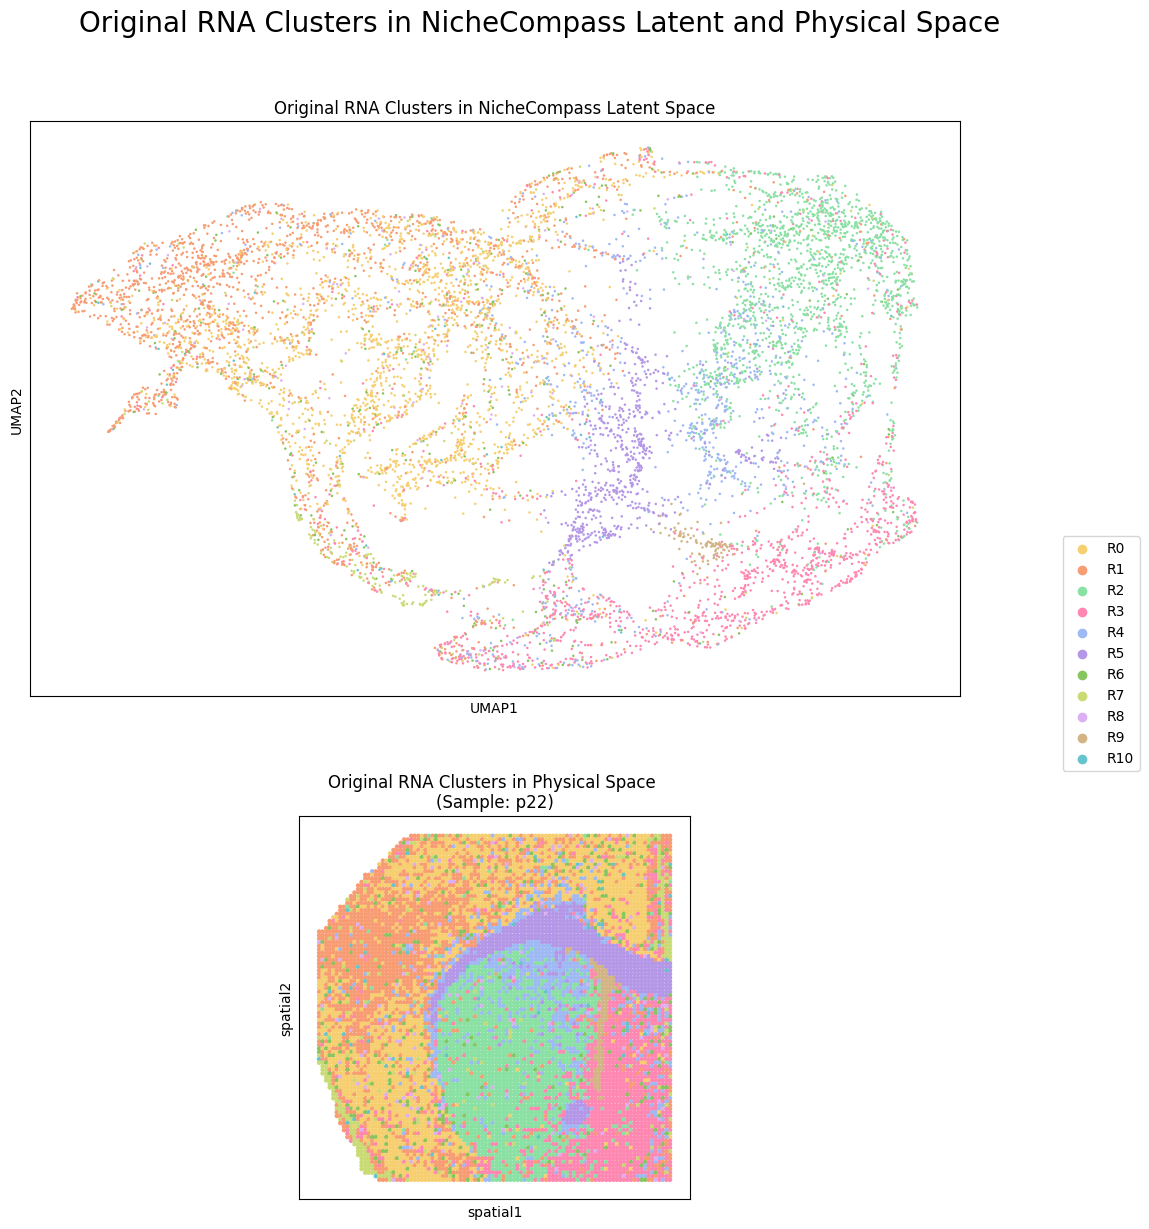

In [98]:
# Create plot of RNA cluster annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["R0"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            "rna_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Original RNA Clusters " \
                       "in NicheCompass Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[rna_cluster_key],
           groups=groups,
           palette=rna_cluster_colors,
           title=f"Original RNA Clusters in NicheCompass Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[rna_cluster_key],
                  groups=groups,
                  palette=rna_cluster_colors,
                  spot_size=spot_size,
                  title=f"Original RNA Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

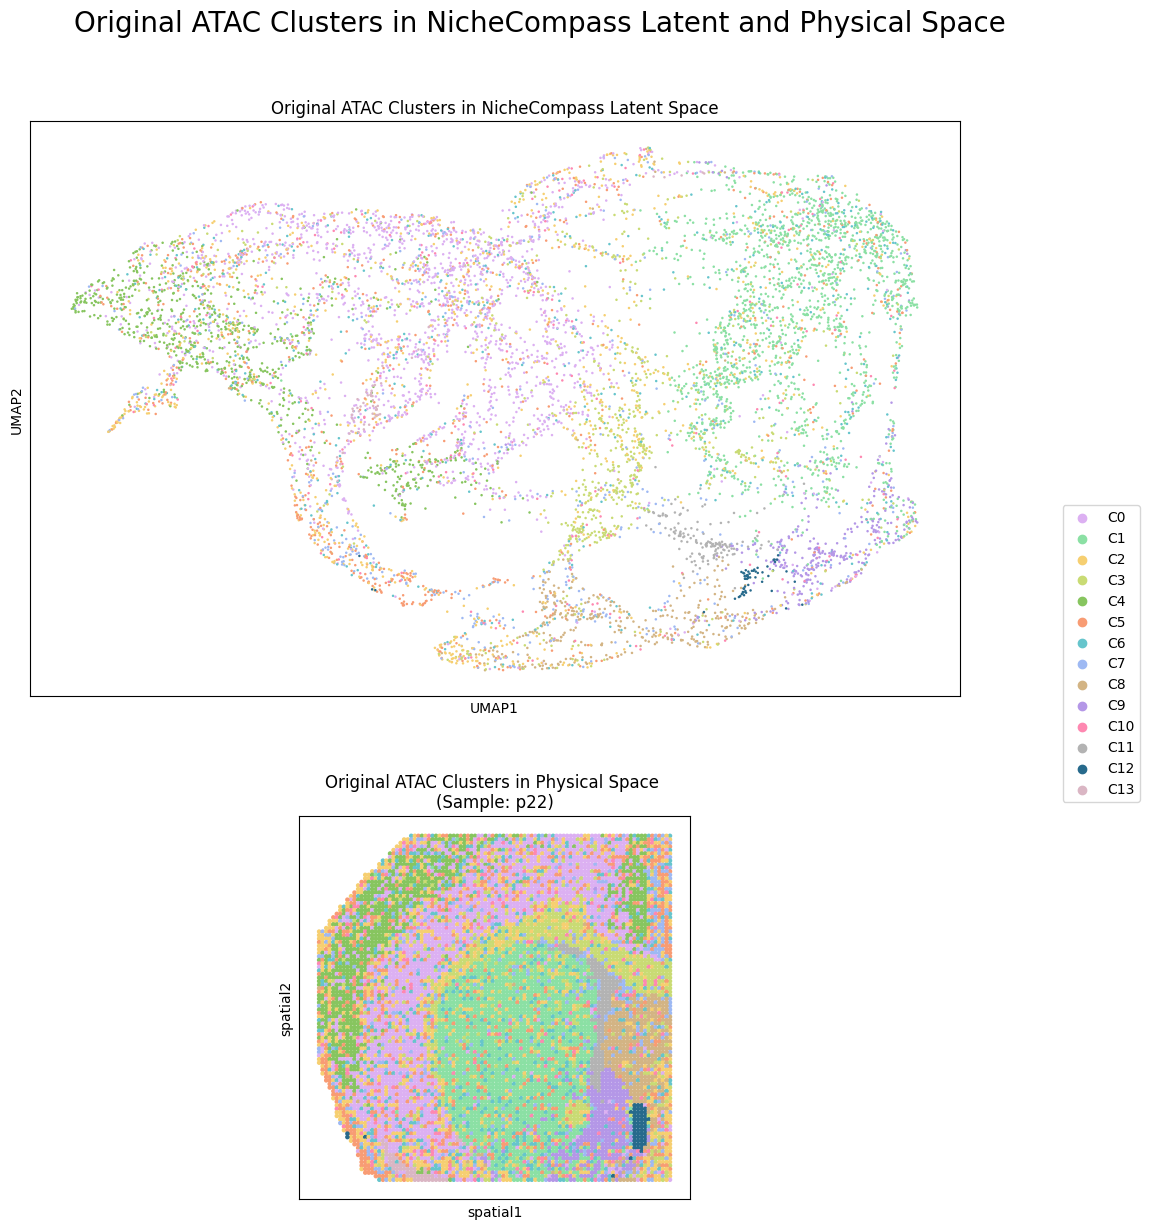

In [99]:
# Create plot of ATAC cluster annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["C0"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            "atac_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Original ATAC Clusters " \
                       "in NicheCompass Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[atac_cluster_key],
           groups=groups,
           palette=atac_cluster_colors,
           title=f"Original ATAC Clusters in NicheCompass Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[atac_cluster_key],
                  groups=groups,
                  palette=atac_cluster_colors,
                  spot_size=spot_size,
                  title=f"Original ATAC Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.2 Identify Niches

We will compute Leiden clustering based on the NicheCompass embeddings to identify spatial cellular niches.

In [100]:
latent_leiden_resolution = 0.45

In [101]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [102]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

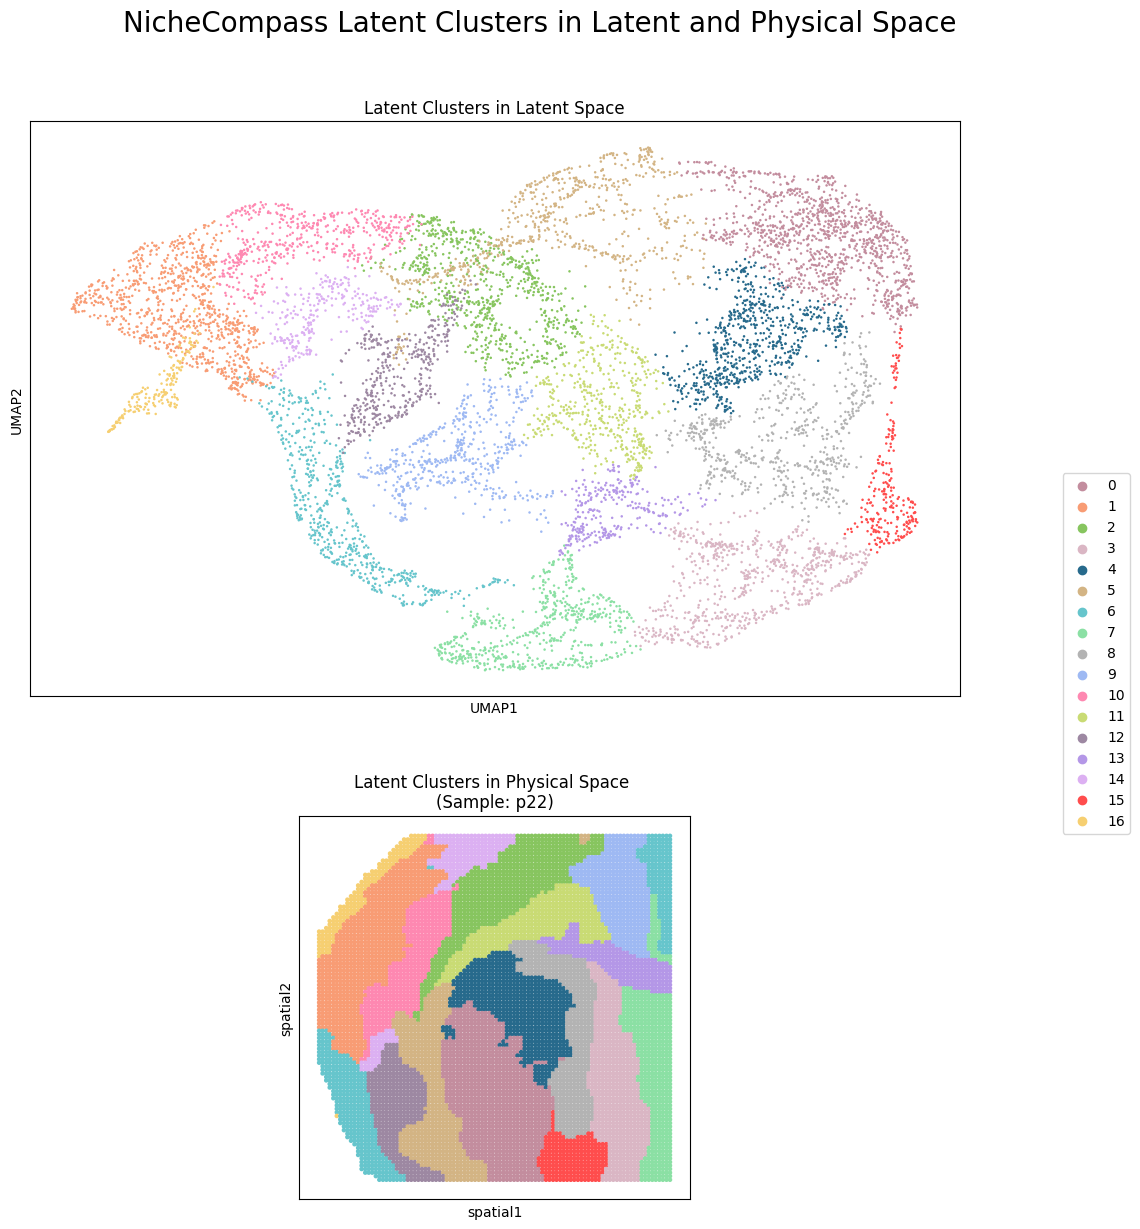

In [103]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["11"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Latent Clusters " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Latent Clusters in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Latent Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

In [105]:
model.adata.obsm["nichecompass_latent"].shape

(9215, 267)

In [132]:
pd.set_option('display.max_columns', None)
summary_df[summary_df["gp_active"] == True][summary_df.columns]

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights_sign_corrected,gp_target_genes_weights_sign_corrected,gp_source_genes_importances,gp_target_genes_importances,n_source_peaks,n_non_zero_source_peaks,n_target_peaks,n_non_zero_target_peaks,gp_source_peaks,gp_target_peaks,gp_source_peaks_weights_sign_corrected,gp_target_peaks_weights_sign_corrected,gp_source_peaks_importances,gp_target_peaks_importances
3,PTPN6_ligand_receptor_GP,3,True,0,1,1,1,1,[Ptpn6],[Clec12a],[0.0251],[-0.0106],[0.7028],[0.2972],3,3,2,2,"[chr6:124731562-124732388, chr6:124729756-1247...","[chr6:129349537-129350347, chr6:129350939-1293...","[0.0151, 0.0055, -0.0029]","[0.0047, 0.0011]","[0.5164, 0.1878, 0.0999]","[0.1594, 0.0366]"
14,GSTO1_ligand_receptor_GP,14,True,1,1,0,1,1,[Gsto1],[Ryr1],[0.0],[0.0342],[0.0011],[0.9989],1,0,9,9,[chr19:47854558-47855451],"[chr7:29088531-29089385, chr7:29022262-2902313...",[0.0],"[-0.0283, -0.0124, 0.0096, -0.0078, -0.0029, 0...",[0.0],"[0.423, 0.1852, 0.1435, 0.1168, 0.0427, 0.0252..."
18,CCL27_ligand_receptor_GP,18,True,2,3,3,1,1,"[Ccl27a, Gm13306, Ccl27b]",[Adra2a],"[0.027, 0.0201, 0.0088]",[0.0018],"[0.4674, 0.348, 0.1528]",[0.0318],1,1,1,1,[chr4:41773733-41774525],[chr19:54044504-54045399],[-0.0019],[0.0055],[0.2513],[0.7487]
19,CXCL1_ligand_receptor_GP,19,True,3,1,1,1,1,[Cxcl1],[Plce1],[0.0172],[0.0243],[0.4147],[0.5853],1,1,19,19,[chr5:90890766-90891723],"[chr19:38478718-38479526, chr19:38778558-38779...",[-0.0031],"[0.0359, 0.0284, 0.027, 0.026, 0.0218, 0.02, 0...",[0.0097],"[0.1115, 0.0882, 0.0838, 0.0806, 0.0677, 0.062..."
37,S100A4_ligand_receptor_GP,37,True,4,1,1,1,1,[S100a4],[Pglyrp1],[-0.0135],[0.0201],[0.4009],[0.5991],1,1,3,3,[chr3:90604296-90605075],"[chr7:18884151-18885005, chr7:18871404-1887227...",[0.0024],"[0.0135, 0.0077, 0.0043]",[0.086],"[0.4854, 0.275, 0.1535]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,Vdr_TF_target_genes_GP,1969,True,262,71,71,71,56,"[Dysf, Sult2b1, Tslp, Casr, Pyy, Tnfrsf21, Cxc...","[Vdr, Fgf23, Sparc, Pyy, Fgf8, Abcb1a, Dysf, E...","[0.5336, 0.4953, 0.4362, 0.3772, 0.3464, 0.313...","[0.3782, 0.1648, 0.0469, 0.0011, 0.0008, 0.000...","[0.0686, 0.0637, 0.0561, 0.0485, 0.0445, 0.040...","[0.0486, 0.0212, 0.006, 1e-04, 1e-04, 1e-04, 1...",302,302,302,215,"[chr17:43016173-43017027, chr7:45784749-457856...","[chr15:97863184-97864075, chr11:55397116-55398...","[0.5307, 0.4735, -0.4461, 0.4315, -0.4164, -0....","[0.1138, -0.0831, -0.0824, -0.0611, 0.0524, -0...","[0.0243, 0.0217, 0.0205, 0.0198, 0.0191, 0.018...","[0.0052, 0.0038, 0.0038, 0.0028, 0.0024, 0.002..."
1974,Wt1_TF_target_genes_GP,1974,True,263,73,73,73,57,"[Adat2, Srpk1, Gnai1, Amhr2, Itga4, Gdnf, Aldh...","[Adat2, Srpk1, Amhr2, Gdnf, Gnai1, Odc1, Wnt4,...","[0.4904, -0.4598, -0.3853, 0.3704, 0.325, 0.20...","[0.4219, -0.3549, 0.214, 0.1372, -0.0688, 0.00...","[0.0687, 0.0644, 0.0539, 0.0519, 0.0455, 0.029...","[0.0591, 0.0497, 0.03, 0.0192, 0.0096, 0.0007,...",312,311,312,223,"[chr17:28622081-28622802, chr5:18305046-183058...","[chr17:28622081-28622802, chr10:13552741-13553...","[-0.4668, 0.4257, -0.4223, -0.4119, 0.4098, 0....","[-0.3984, -0.3074, 0.2993, 0.2187, 0.1964, 0.1...","[0.0193, 0.0176, 0.0175, 0.017, 0.0169, 0.0168...","[0.0165, 0.0127, 0.0124, 0.009, 0.0081, 0.0074..."
1981,Yy1_TF_target_genes_GP,1981,True,264,98,98,98,97,"[Tln2, Slamf7, Kif14, Tnfrsf4, Wdfy4, Postn, C...","[Slamf7, Wdfy4, Dnm1, Kif14, Tln2, Tnfrsf4, Vw...","[-0.483, 0.431, 0.4305, 0.428, 0.4176, 0.3462,...","[0.4405, 0.3986, -0.3679, 0.3173, -0.3115, 0.2...","[0.0211, 0.0188, 0.0188, 0.0187, 0.0182, 0.015...","[0.0192, 0.0174, 0.016, 0.0138, 0.0136, 0.0129...",451,451,451,438,"[chr10:76531047-76531965, chr2:119477411-11947...","[chr10:76531047-76531965, chr2:119477411-11947...","[0.4778, 0.4722, 0.4495, -0.4112, 0.4043, -0.3...","[0.4304, 0.4251, -0.417, -

In [161]:
model.add_active_gp_expr_to_obs()

In [138]:


gp = "Yy1_TF_target_genes_GP"
combined_new_gp_dict[gp]
source_gene = combined_new_gp_dict[gp]["sources"][0].lower().capitalize()
target_gene = combined_new_gp_dict[gp]["targets"][0].lower().capitalize()

In [147]:
model.adata.obs.drop(["Yy1_TF_target_genes_GP"], axis=1, inplace=True)

In [154]:
np.mean(np.abs(model.adata.obs["Yy1_TF_target_genes_GP"]))

2.18763096829471

In [159]:
model.adata.obs.drop(["PTPN6_ligand_receptor_GP"], axis=1, inplace=True)

In [162]:
np.mean(np.abs(model.adata.obs["PTPN6_ligand_receptor_GP"]))

12.712356635822742

In [164]:
model.adata.obsm["nichecompass_latent"].shape

(9215, 267)

In [167]:
gp_weights = model.model.get_gp_weights(only_masked_features=True)[0]

In [171]:
abs_gp_scores_sums = torch.tensor(model.adata.obsm["nichecompass_latent"]).norm(p=1, dim=0)

In [183]:
gp_weights_test = gp_weights[:, :267]

In [ ]:
gp_weights_test

In [184]:
abs_gp_scores_sums * gp_weights_test

tensor([[0., -0., 0.,  ..., 0., 0., 0.],
        [-0., -0., 0.,  ..., -0., -0., 0.],
        [0., -0., -0.,  ..., 0., 0., 0.],
        ...,
        [0., -0., -0.,  ..., -0., -0., -0.],
        [0., 0., -0.,  ..., 0., -0., 0.],
        [0., -0., -0.,  ..., 0., -0., 0.]], dtype=torch.float64)

In [182]:
gp_weights_test

torch.Size([6771, 267])

In [189]:
model.model.adata

AttributeError: 'VGPGAE' object has no attribute 'adata'

In [181]:
abs_gp_scores_sums

tensor([117144.3664, 132850.4408, 127232.2313,  95586.6570,  90765.3206,
         91560.4350,  81989.5168, 103932.8323,  74378.3422,  52857.7249,
        131512.0346,  78313.3620, 136736.8453,  65994.2575, 127375.6303,
         73386.6173, 110609.4199,  67412.9716,  11301.3556,  11341.0782,
          7884.2793,   9704.9775,  16032.5280,  14344.4220,   9706.2272,
         11620.0018,  14911.8861,   6865.2800,  11023.4326,   7218.5468,
         12965.1048,  16221.1599,  11631.8509,  19333.0729,  15433.0768,
         10938.2002,  10611.6600,  13244.9777,  12062.9226,   9391.1138,
         14703.8707,   9949.2089,  15548.1452,   8069.6595,   9987.2427,
         19589.3042,  15104.2573,  10496.9658,  14936.7671,  16083.1289,
         11700.3902,   8413.9572,   8802.0139,  11088.2481,   8648.5199,
         10894.5530,  13162.5033,  14288.9177,  13369.9659,  13708.1236,
         10921.9277,  13860.4961,  10475.6845,  12387.3470,  12229.7243,
         11631.0906,  12936.4880,   8339.9901,   94

In [173]:
abs_gp_scores_sums.shape

torch.Size([267])

In [168]:
gp_weights.shape

torch.Size([6771, 2041])

In [ ]:
mode

In [151]:
sc.pl.spatial(
    adata=model.adata,
    color=gp,
    color_map="RdBu_r",
    spot_size=30,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True) 


KeyboardInterrupt



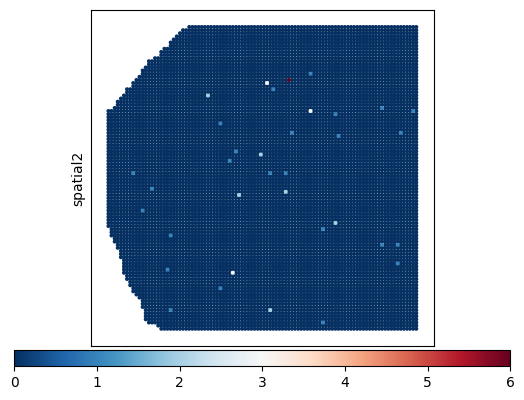

In [119]:
sc.pl.spatial(
    adata=model.adata,
    color=source_gene,
    color_map="RdBu_r",
    spot_size=30,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True) 

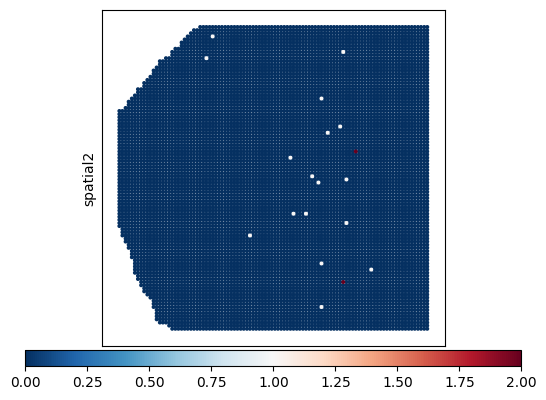

In [120]:
sc.pl.spatial(
    adata=model.adata,
    color=target_gene,
    color_map="RdBu_r",
    spot_size=30,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True) 

### 4.3 Analyze Niches

#### 4.3.1 Niche Composition

We can analyze the niche composition in terms of rna cluster spot labels.

In [ ]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, rna_cluster_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True)
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("RNA Cluster", prop={'size': 10})
plt.title("RNA Cluster Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("RNA Cluster Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

#### 4.3.2 Spot Annotation Neighbor Importances

Now we will investigate neighbor importances in terms of rna cluster spot labels of different niches.

In [ ]:
# Retrieve node neighbor importances 
# (aggregation weights of the node label aggregator)
model.adata.obsp[agg_weights_key] = model.get_neighbor_importances()

In [ ]:
# Get cell type neighbor importances for each niche / latent cluster
niche_neighbor_importances_df = aggregate_obsp_matrix_per_cell_type(
    adata=model.adata,
    obsp_key=agg_weights_key,
    cell_type_key=rna_cluster_key,
    group_key=latent_cluster_key,
    agg_rows=True)

In [ ]:
display(niche_neighbor_importances_df)

In [ ]:
# Generate chord plots showing cell type neighbor importances
# for each niche / latent cluster
groups = "all"
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_neighbor_importances.png"

create_cell_type_chord_plot_from_df(
        adata=model.adata,
        df=niche_neighbor_importances_df,
        link_threshold=0.01,
        cell_type_key=rna_cluster_key,
        group_key=latent_cluster_key,
        groups=groups,
        plot_label="Niche",
        save_fig=save_fig,
        file_path=file_path)

### 4.4 Perform Differential Gene Program Testing

Now we can test which communication gene programs are differentially expressed in a niche. To this end, we will perform differential gene program testing for each latent cluster / niche (```selected_cats = None```)  vs all other latent clusters / niches (```comparison_cats = "rest"```).

We could also perform differential gene program testing for a selected niche only, e.g. latent cluster / niche "11" (```selected_cats = ["11"]```) or test only against specified latent clusters / niches, e.g. niches "2" and "3" (```comparison_cats = ["2", "3"]```).

We choose a log bayes factor threshold of 4.6 to determine decisively enriched gene programs. Alternatively, the threshold could be loosened to a value of 2.3 to also allow "only" strongly enriched gene programs to be identified (see https://en.wikipedia.org/wiki/Bayes_factor).

In [ ]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

In [ ]:
# Set parameters for differential gp testing
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Latent Cluster Decisively Enriched Gene Programs"
log_bayes_factor_thresh = 4.6 # 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
             "all_niches_vs_rest_enriched_gps_dotplot.svg"

In [ ]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [ ]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

In [ ]:
# Create dotplot of results
fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=latent_cluster_key,
                    expression_cutoff=-np.inf,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
sc.pl.spatial(model.adata, color=["Hoxc9_TF_target_genes_GP"], spot_size=30)

In [ ]:
sc.pl.spatial(model.adata, color=["Myc_TF_target_genes_GP"], spot_size=30)

In [ ]:
enriched_gps

In [ ]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "all_niches_vs_rest_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances",
                   "n_source_peaks",
                   "n_target_peaks",
                   "gp_source_peaks",
                   "gp_target_peaks",
                   "gp_source_peaks_weights_sign_corrected",
                   "gp_target_peaks_weights_sign_corrected",
                   "gp_source_peaks_importances",
                   "gp_target_peaks_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

### 4.5 Analyze Enriched Gene Programs

Now we will have a look at the gene program scores as well as the (log normalized) count distributions of
the most important omics features of the differentially expressed gene programs.

In [ ]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_all_niches_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gps=30,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=5,
    n_top_peaks_per_gp=5,
    log_norm_omics_features=True,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)